In [13]:
# load some library needed and functions

import os
import json
import sounddevice as sd
import soundfile as sf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import lbg


# Definition of Variables


In [14]:
duration_s = 2
fs = 44100
num_mfcc = 13
frame_lenght = 1024
hop_lenght = 512
cb_depth = 8
#TODO threshold

In [17]:
def record_audio(seconds, user_name, entry):
    fs = 44100  # Sampling frequency
    duration = seconds  # Duration of recording in seconds
    
    
    print("Recording...")

    
    # Record audio from the microphone
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.float32)
    sd.wait()

    print("Finished recording.")

    if user_name:
        filename = f"voice_{user_name}_{entry}.wav"
        folder_path = os.path.join(os.getcwd(), 'Users_samples', user_name, filename)
        # Save audio to file
        sf.write(folder_path, audio, fs, subtype='PCM_24')
        print(f"Audio recorded and saved as {folder_path}")
    
    
    return audio, fs


def extract_mfcc_file(audio_file, num_mfcc, frame_length, hop_length):
    # Load audio file
    y, sr = librosa.load(audio_file)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)

    return mfccs

def extract_mfcc(audio_waveform, sr, num_mfcc, frame_length, hop_length):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_waveform, sr=sr, n_mfcc=num_mfcc, n_fft=frame_length, hop_length=hop_length)

    return mfccs

def calculate_distortion(sample_mfcc, codebook):
    # Initialize total distortion
    total_distortion = 0.0
    
    # Assign each sample MFCC to its nearest centroid in the codebook
    nearest_centroids = np.argmin(np.linalg.norm(sample_mfcc[:, None, :] - codebook, axis=2), axis=1)
    
    # Calculate the Euclidean distance between each sample MFCC and its assigned centroid
    for i, centroid_index in enumerate(nearest_centroids):
        centroid = codebook[centroid_index]
        distortion = np.linalg.norm(sample_mfcc[i] - centroid)
        total_distortion += distortion
        # for average distortion, divide the total by sample_mfcc.shape[0]
    return total_distortion


def create_user_folder(user_name):
    # Create folder path
    user_folder='Users_samples'
    folder_path = os.path.join(os.getcwd(), user_folder, user_name)

    # Check if folder exists
    if not os.path.exists(folder_path):
        # Create folder if it doesn't exist
        os.makedirs(folder_path)
        print(f"Folder '{user_name}' created successfully.")
    else:
        print(f"Folder '{user_name}' already exists.")
    
    file_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
    return file_count, folder_path

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]


### If needed audio file can be rescaled to defined range using the following

In [3]:
# audio = scale_list(audio,-1,1)

NameError: name 'audio' is not defined

# Add users to database and create filesystem

In [19]:

user_name = input("Enter your name: ")
entry, folder = create_user_folder(user_name)

audio_file, fs = record_audio(duration_s, user_name, entry+1)
audio = audio_file.reshape(-1)

Folder 'Facundo' already exists.
Recording...
Finished recording.
Audio recorded and saved as c:\Users\books\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\Documents\0_TEC\6to semestre\TE2010B Desarrollo de sistemas de procesamiento digital de señales\Python\Users_samples\Facundo\voice_Facundo_2.wav


# Create codebooks

In [20]:
user_folder='Users_samples'
users_folder= os.path.join(os.getcwd(), user_folder)

codebook_folder_rel='Codebooks'
codebook_folder= os.path.join(os.getcwd(), codebook_folder_rel)

folder_names = [name for name in os.listdir(users_folder) if os.path.isdir(os.path.join(users_folder, name))]


audio_per_user = {}
mfccs_per_user = {}
codebook_per_user = {}

for folder_name in folder_names:
    folder_path = os.path.join(users_folder, folder_name)
    # Check if folder exists
    if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
        print(f"Folder '{folder_name}' does not exist or is not a directory. Skipping.")
        continue

    # Read audio files in the folder
    concatenated_audio = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if file is an audio file
        if filename.endswith('.wav') or filename.endswith('.mp3'):
            print(f"Reading audio file: {filename}")
            audio, sr = librosa.load(file_path, sr=fs)
            normalized_audio = audio / np.max(np.abs(audio))
            concatenated_audio.extend(audio)


    audio_per_user[folder_name] = concatenated_audio
  
for user in audio_per_user:
    num_mfcc = num_mfcc  # Number of MFCC coefficients, global variable
    frame_length = frame_lenght  # Frame length for STFT
    hop_length = hop_lenght  # Hop length for STFT
    audio_user=np.array(audio_per_user[user])
    
    mfccs_per_user[user] = extract_mfcc(audio_user, fs, num_mfcc, frame_length, hop_length)
    cb, cb_abs_w, cb_rel_w = lbg.generate_codebook(mfccs_per_user[user].T, cb_depth)
    codebook_per_user[user] = cb
    
with open(os.path.join(codebook_folder, 'Codebook'), 'w') as f:
    json.dump(codebook_per_user, f)  
    
print("Finished creating Codebook.")    

Reading audio file: voice_Cesar_1.wav
Reading audio file: voice_Cesar_2.wav
Reading audio file: voice_Cesar_3.wav
Reading audio file: voice_Facundo_1.wav
Reading audio file: voice_Facundo_2.wav
Reading audio file: voice_Katia_1.wav
Reading audio file: voice_Katia_2.wav
Reading audio file: voice_Katia_3.wav
Finished creating Codebook.


# Read the codebook and identify speaker

In [23]:

entry = input("Press a key to enter a voice sample for identification: ")
audio_file, fs = record_audio(2, "", "")

audio = audio_file.reshape(-1)

num_mfcc = num_mfcc  # Number of MFCC coefficients
frame_length = frame_lenght  # Frame length for STFT
hop_length = hop_lenght  # Hop length for STFT

mfccs = extract_mfcc(audio, fs, num_mfcc, frame_length, hop_length)

print("Loading Codebook ... ")

with open(os.path.join(codebook_folder, 'Codebook'), 'r') as f:
        stored_codebook = json.load(f)

# calculate distortions

print("User\tDistortion")
print("----------------")
for user, cb in stored_codebook.items():
    distortion = calculate_distortion(mfccs.T, cb)
    print(f"{user}\t{distortion}")



Recording...
Finished recording.
Loading Codebook ... 
User	Distortion
----------------
Cesar	8008.29137300872
Katia	11423.720307009404


# Plot the features and centroids

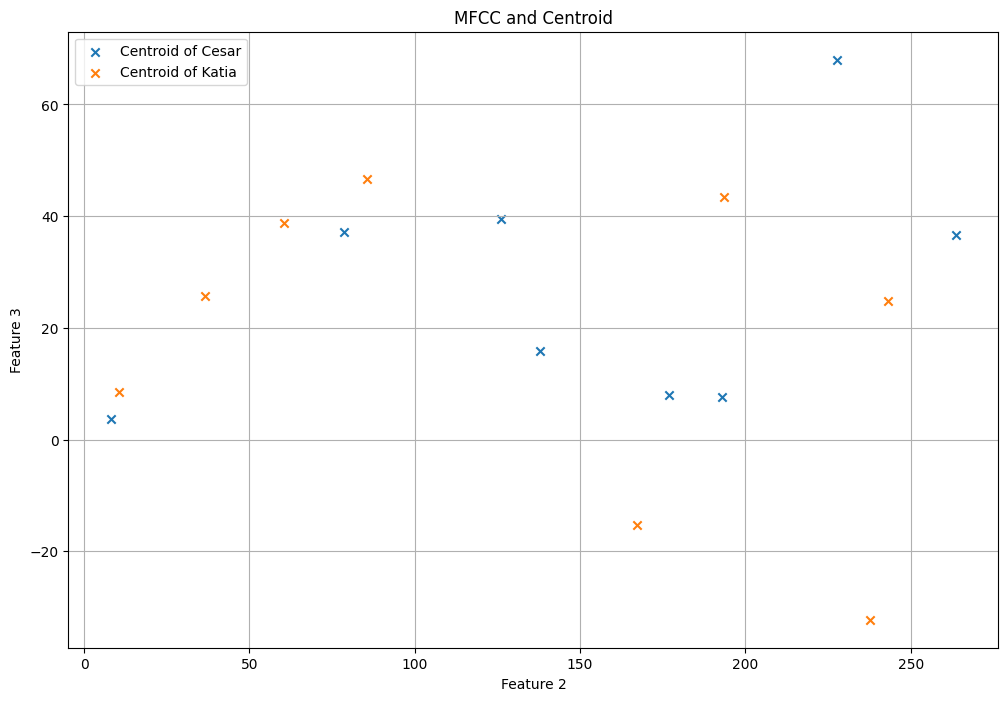

In [15]:
feature1_idx = 1  
feature2_idx = 2

plt.figure(figsize=(12, 8)) 

for user, sample_mfcc in mfccs_per_user.items():
    # Plot MFCC
    #plt.scatter(sample_mfcc[feature1_idx,:], sample_mfcc[feature2_idx,:], label=user)
    # Plot centroid
    cb_stored=np.array(stored_codebook[user])
    plt.scatter(cb_stored[:,feature1_idx], cb_stored[:,feature2_idx], label=f'Centroid of {user}', marker='x')
   
plt.xlabel(f'Feature {feature1_idx+1}')
plt.ylabel(f'Feature {feature2_idx+1}')
plt.title(f'MFCC and Centroid')
plt.legend()
plt.grid(True)
plt.show()
    
    